# **Проект по анализу данных**
## **Анализ каталога вин интернет-магазина SimpleWine**
#### Выполнили: Амзина Полина и Ким Ми Ра

Изначально мы планировали выполнить проект по прогнозированию количества скачиваний приложений с сервисов applestore и googlestore. К сожалению, мы столкнулись с проблемой однообразия данных и малой их дифференциаций, в связи с чем было принято решение сменить тему.

Для начала нам было необходимо собрать данные с сайта simplewine.ru. Парсинг описан в файле parsing.ipynb. Собранные данные лежат в data.csv. Данные загружаем из этого файла.

In [4]:
import numpy as np
import pandas as pd

import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv('data.csv', on_bad_lines='skip')
print(df.shape)
df.head()

(5571, 10)


,name,country,color,sugar,volume,manufacturer,region,grape,year,price
0,Shiraz Mr Borio's,Южная Африка,красное,сухое,0.75 л.,Simonsig,Стелленбош,шираз 100%,2020 г.,2 990
1,Gavi dei Gavi (Etichetta Nera),Италия,белое,сухое,0.75 л.,La Scolca,Пьемонт,кортезе 100%,2022 г.,5 990
2,Красностоп Золотовский на Террасах,Россия,красное,сухое,0.75 л.,Сикоры,Кубань,красностоп 100%,2018 г.,5 490
3,Vermentino di Toscana,Италия,белое,сухое,0.75 л.,Fattoria del Cerro,Тоскана,верментино,2022 г.,2 490
4,Pfefferer,Италия,белое,полусухое,0.75 л.,Colterenzio,Трентино-Альто Адидже,мускат желтый 100%,2023 г.,2 490


В датасете содержится 5571 различных вин

### Описание переменных:
* **name** — название вина
* **country** — страна производства
* **color** — цвет вина
* **sugar** — сладость вина
* **volume** — объем одной бутылки в литрах
* **manufacturer** — производитель
* **region** — регион производства
* **grape** — сорт винограда
* **year** — год производства
* **price** — цена за бутылку в рублях (целевая переменная)


Посмотрим есть ли в данных пропуски


In [8]:
df.isnull().sum()

name             4
country          0
color            0
sugar            0
volume           0
manufacturer     0
region           0
grape            0
year            76
price            0
dtype: int64

Как можно заметить в данных не хватает 4 наименований вин и 76 годов производства. Так как название вина не является значимой переменной в предсказании цены за бутылку вина (не в нашем исследовании), то не имеет смысла как-то пытаться заместить пропущенные значения. Год производства играет немаловажную роль в прогнозировании цен, поэтому было принято решение удалить вина с пропущенными значениеми.

In [9]:
df.dropna(subset=['year'])
df.head()

,name,country,color,sugar,volume,manufacturer,region,grape,year,price
0,Shiraz Mr Borio's,Южная Африка,красное,сухое,0.75 л.,Simonsig,Стелленбош,шираз 100%,2020 г.,2 990
1,Gavi dei Gavi (Etichetta Nera),Италия,белое,сухое,0.75 л.,La Scolca,Пьемонт,кортезе 100%,2022 г.,5 990
2,Красностоп Золотовский на Террасах,Россия,красное,сухое,0.75 л.,Сикоры,Кубань,красностоп 100%,2018 г.,5 490
3,Vermentino di Toscana,Италия,белое,сухое,0.75 л.,Fattoria del Cerro,Тоскана,верментино,2022 г.,2 490
4,Pfefferer,Италия,белое,полусухое,0.75 л.,Colterenzio,Трентино-Альто Адидже,мускат желтый 100%,2023 г.,2 490


После очистки датасета у нас получилось 5495 элемента, которые мы будем анализировать в дальнейшем

In [10]:
unique_country = df['country'].nunique()
print("Количество стран - производителей вина:", unique_country)

unique_color = df['color'].nunique()
print("Количество уникальных видов вина по виду:", unique_color)

unique_sugar = df['sugar'].nunique()
print("Количество уникальных видов вина по сладости:", unique_sugar)

unique_manufacturer = df['manufacturer'].nunique()
print("Количество уникальных производителей вина:", unique_manufacturer)

unique_grape = df['grape'].nunique()
print("Количество уникальных составляющих вина:", unique_grape)

unique_volume = df['volume'].nunique()
print("Количество возможных объемов бутылки вина:", unique_volume)

unique_year = df['year'].nunique()
print(f"Датасет охватывает бутылки вина, произведенные в {unique_year} разных годах")



Количество стран - производителей вина: 20
Количество уникальных видов вина по виду: 5
Количество уникальных видов вина по сладости: 8
Количество уникальных производителей вина: 527
Количество уникальных составляющих вина: 970
Количество возможных объемов бутылки вина: 16
Датасет охватывает бутылки вина, произведенные в 37 разных годах


Для дальнейшего анализа необходимо преобразить некоторые столбцы в таблице. (Преобразование будет не по порядку, а по важности для нас)

**Преображение колонки price.**

Для перевода строк в числа была написана функция, которая сначала убирает пробелы между разрядами, а потом переводит получившуюся строку в число

In [11]:
def correct(value: str):
    correct = int(value.replace(' ', ''))
    return correct


In [12]:
df = pd.DataFrame(df)
k = df['price'].map(correct)

df['price'] = k
df.head()

,name,country,color,sugar,volume,manufacturer,region,grape,year,price
0,Shiraz Mr Borio's,Южная Африка,красное,сухое,0.75 л.,Simonsig,Стелленбош,шираз 100%,2020 г.,2990
1,Gavi dei Gavi (Etichetta Nera),Италия,белое,сухое,0.75 л.,La Scolca,Пьемонт,кортезе 100%,2022 г.,5990
2,Красностоп Золотовский на Террасах,Россия,красное,сухое,0.75 л.,Сикоры,Кубань,красностоп 100%,2018 г.,5490
3,Vermentino di Toscana,Италия,белое,сухое,0.75 л.,Fattoria del Cerro,Тоскана,верментино,2022 г.,2490
4,Pfefferer,Италия,белое,полусухое,0.75 л.,Colterenzio,Трентино-Альто Адидже,мускат желтый 100%,2023 г.,2490


**Преображение колонки grape.**

Нами было замечено, что если вино состоит из нескольких сортов винограда, то в таблице между ними появляется "&", для более привлекательного вида мы избавимся от этого разделителя.

In [13]:
def corrected(value: str):
    corrected = value.replace('&', ', ')
    return corrected

In [15]:
z = df['grape'].map(corrected)
df['grape'] = z
df

,name,country,color,sugar,volume,manufacturer,region,grape,year,price
0,Shiraz Mr Borio's,Южная Африка,красное,сухое,0.75 л.,Simonsig,Стелленбош,шираз 100%,2020 г.,2990
1,Gavi dei Gavi (Etichetta Nera),Италия,белое,сухое,0.75 л.,La Scolca,Пьемонт,кортезе 100%,2022 г.,5990
2,Красностоп Золотовский на Террасах,Россия,красное,сухое,0.75 л.,Сикоры,Кубань,красностоп 100%,2018 г.,5490
3,Vermentino di Toscana,Италия,белое,сухое,0.75 л.,Fattoria del Cerro,Тоскана,верментино,2022 г.,2490
4,Pfefferer,Италия,белое,полусухое,0.75 л.,Colterenzio,Трентино-Альто Адидже,мускат желтый 100%,2023 г.,2490
...,...,...,...,...,...,...,...,...,...,...
5566,Pommard,Франция,красное,сухое,0.375 л.,Joseph Drouhin,Бургундия,пино нуар 100%,2018 г.,11190
5567,L`Apparita,Италия,красное,сухое,0.75 л.,Castello di Ama,Тоскана,мерло 100%,2016 г.,67490
5568,Meursault-Charmes Premier Cru Les Charmes Dessus,Франция,белое,сухое,0.75 л.,Domaine Antonin Guyon,Бургундия,шардоне 100%,2020 г.,31490
5569,Saint-Joseph Cavanos,Франция,красное,сухое,0.375 л.,Yves Cuilleron,Долина Роны,сира 100%,2018 г.,4990


**Преображение колонки volume.**

Для дальнейшей работы необходимо перевести год в числовое значение. Пристальным взглядом (и поломкой кода) было замечено, что для некоторых вин отсутсвовала информация по сладости, в следствие чего при парсинге значения из последующих колонок (объем, мануфактура и тд.) переносились на предыдущие, что крайне осложняло перевод типа данных. В связи с этим было принято решение удалить все вина, у которых произошло смещение данных.

In [16]:
indices_to_drop = []
for index, item in enumerate(df['volume']):
    if any(word in item for word in ['турига франка', 'турига насьональ', 'тинта рориш', 'тинта као', 'тинта баррока', 'сухое', 'мальвазия фина', 'кодега']):
        indices_to_drop.append(index)

df.drop(indices_to_drop, inplace=True)

#Эту функцию написал чат ГПТ. Проводка:
#ind = 0
#for item in df.volume:
  #ind += 1
  #if ('турига франка' or 'турига насьональ' or 'тинта рориш' or 'тинта као' or 'тинта баррока' or 'сухое' or 'мальвазия фина' or 'кодега') in item:
    #df.drop(index = (ind-1) )
#сделать этот код рабочим, так чтобы он удалял строки из таблицы в колонке "объем", которой содержатся 'турига франка' or 'турига насьональ' or 'тинта рориш' or 'тинта као' or 'тинта баррока' or 'сухое' or 'мальвазия фина' or 'кодега'

In [17]:
def correct_year(value: str):
    correct_year = value.replace('\xa0л.', '')
    return correct_year

In [18]:
a = df['volume'].map(correct_year)
df['volume'] = a
df.head()

,name,country,color,sugar,volume,manufacturer,region,grape,year,price
0,Shiraz Mr Borio's,Южная Африка,красное,сухое,0.75,Simonsig,Стелленбош,шираз 100%,2020 г.,2990
1,Gavi dei Gavi (Etichetta Nera),Италия,белое,сухое,0.75,La Scolca,Пьемонт,кортезе 100%,2022 г.,5990
2,Красностоп Золотовский на Террасах,Россия,красное,сухое,0.75,Сикоры,Кубань,красностоп 100%,2018 г.,5490
3,Vermentino di Toscana,Италия,белое,сухое,0.75,Fattoria del Cerro,Тоскана,верментино,2022 г.,2490
4,Pfefferer,Италия,белое,полусухое,0.75,Colterenzio,Трентино-Альто Адидже,мускат желтый 100%,2023 г.,2490


**Преображение колонки country.**

In [68]:
unique_countries = df['country'].unique()
print("Страны - производители вина:", unique_countries)


Страны - производители вина: ['Южная Африка' 'Италия' 'Россия' 'Аргентина' 'Франция' 'Испания'
 'Австралия' 'Германия' 'Австрия' 'Новая Зеландия'
 'Соединенные Штаты Америки' 'Чили' 'Португалия' 'Грузия' 'Венгрия'
 'Армения' 'Греция' 'Республика Молдова' 'Словения' 'Сербия']


Так как в данных представлены с разных континентов, то для дальнейшей работы было решено объединить страны по континентам. Так, к Европе относятся: Италия, Россия, Франция, Испания, Германия, Австрия, Португалия, Грузия, Венгрия, Армения, Греция, Республика Молдова, Словения, Сербия. К Америке (Южная и Северная): Аргентина, Чили, Соединенные Штаты Америки. Африку представляет Южная Африка. Океанию -- Австралия и Новая Зеландия.



In [1]:
afric = ['Южная Африка']
europe = ['Италия', 'Россия', 'Франция', 'Испания', 'Германия', 'Австрия', 'Португалия', 'Грузия', 'Венгрия',
 'Армения', 'Греция', 'Республика Молдова', 'Словения', 'Сербия']
america = ['Аргентина', 'Соединенные Штаты Америки', 'Чили']
ocean = ['Новая Зеландия', 'Австралия']

В дальнейшем мы планируем сделать дополнительную колонку "континет". Пока в разработке ....

**Преображение колонки year.**

In [44]:
def correct_years(value: str):
    correct_years = str(value).replace('\xa0г.', '')
    return correct_years

#При применении функции компьютер почему-то стринговые данные считал вещественными, поэтому сначала пришлось поменять их тип
#Я не знаю почему, но питон не дает мне поменять тип данных на целочисленный. Он вечно выдает какие-то ошибки, поэтому пусть остается пока так.

In [43]:
p = df['year'].map(correct_years)
df['year'] = p
df.head()

,name,country,color,sugar,volume,manufacturer,region,grape,year,price
0,Shiraz Mr Borio's,Южная Африка,красное,сухое,0.75,Simonsig,Стелленбош,шираз 100%,2020,2990
1,Gavi dei Gavi (Etichetta Nera),Италия,белое,сухое,0.75,La Scolca,Пьемонт,кортезе 100%,2022,5990
2,Красностоп Золотовский на Террасах,Россия,красное,сухое,0.75,Сикоры,Кубань,красностоп 100%,2018,5490
3,Vermentino di Toscana,Италия,белое,сухое,0.75,Fattoria del Cerro,Тоскана,верментино,2022,2490
4,Pfefferer,Италия,белое,полусухое,0.75,Colterenzio,Трентино-Альто Адидже,мускат желтый 100%,2023,2490


Посмотрим, что осталось от изначальных данных.

In [20]:
unique_country = df['country'].nunique()
print("Количество стран - производителей вина:", unique_country)

unique_color = df['color'].nunique()
print("Количество уникальных видов вина по типу:", unique_color)

unique_sugar = df['sugar'].nunique()
print("Количество уникальных видов вина по сладости:", unique_sugar)

unique_manufacturer = df['manufacturer'].nunique()
print("Количество уникальных производителей вина:", unique_manufacturer)

unique_grape = df['grape'].nunique()
print("Количество уникальных составляющих вина:", unique_grape)

unique_volume = df['volume'].nunique()
print("Количество возможных объемов бутылки вина:", unique_volume)

unique_year = df['year'].nunique()
print(f"Датасет охватывает бутылки вина, произведенные в {unique_year} разных годах")

Количество стран - производителей вина: 20
Количество уникальных видов вина по типу: 3
Количество уникальных видов вина по сладости: 4
Количество уникальных производителей вина: 523
Количество уникальных составляющих вина: 954
Количество возможных объемов бутылки вина: 9
Датасет охватывает бутылки вина, произведенные в 36 разных годах


По некоторым показателям изменилось количество уникальных признаков. Это говорит о том, что при парсинге признаки поменялись местами, что вело к ошибкам в коде.

## **Визуализация данных**

* Данные по объему вина

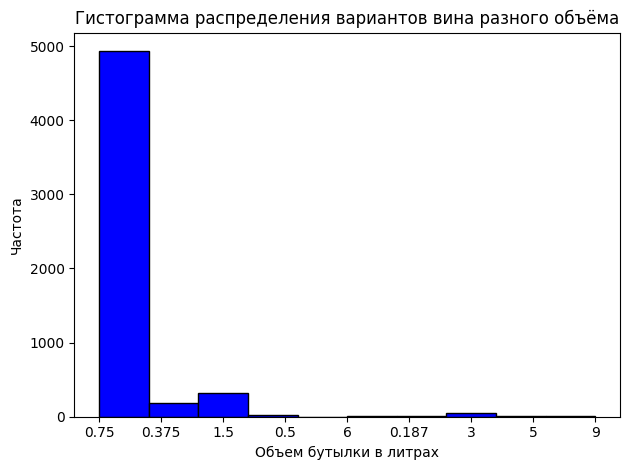

In [21]:
plt.hist(df.volume, bins=10, color='blue', edgecolor='black')
plt.title(f'Гистограмма распределения вариантов вина разного объёма')
plt.xlabel('Объем бутылки в литрах')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

По гистограмме можно сказать, что на сайте simplewine.ru в основном представлены бутылки вина объемом 0.75 литра. Так же на сайте в немногочисленном объеме представлены бутылки объемом 0.187, 3, 5, 6 и 9 литров.

* Данные по типу вина

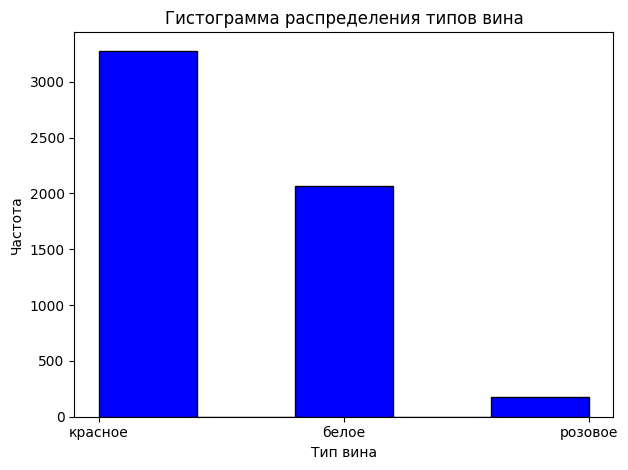

In [24]:
plt.hist(df.color, bins=5, color='blue', edgecolor='black')
plt.title(f'Гистограмма распределения типов вина')
plt.xlabel('Тип вина')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

На гистограмме видно, что больше половины выборки приходится на красные вина. Белые вина также представлены в довольно большом объеме, чего нельзя сказать о розовых винах.

* Данные по годам

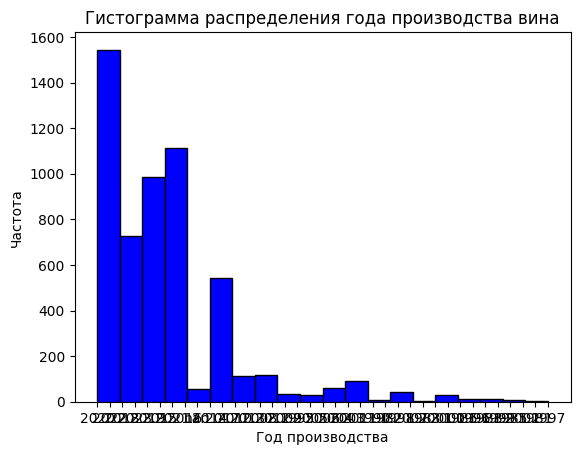

In [48]:
plt.hist(df.year, bins=20, color='blue', edgecolor='black')
plt.title(f'Гистограмма распределения года производства вина')
plt.xlabel('Год производства')
plt.ylabel('Частота')


plt.show()

* Данные по стране производства

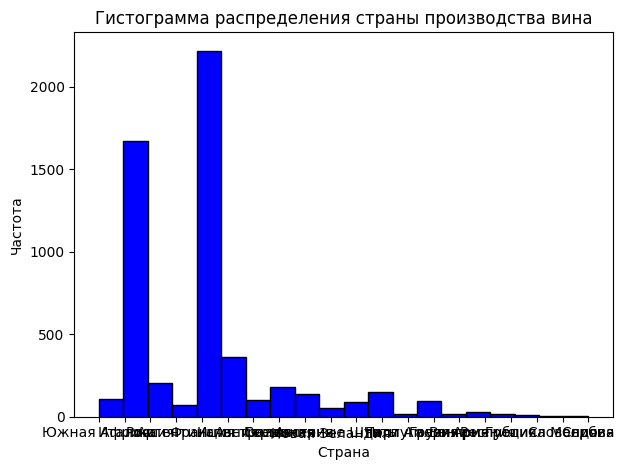

In [26]:
plt.hist(df.country, bins=20, color='blue', edgecolor='black')
plt.title(f'Гистограмма распределения страны производства вина')
plt.xlabel('Страна')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

График получился некрасивым из-за наложения текста друг на друга. При этом, можно заметить, что две страны особо выделяются на фоне остальных. Это Италия и Франция. В последующем мы постоим гистрограмму для континетов. Предсказуемо, Европа будет лидировать.

* Данные о сладости вина

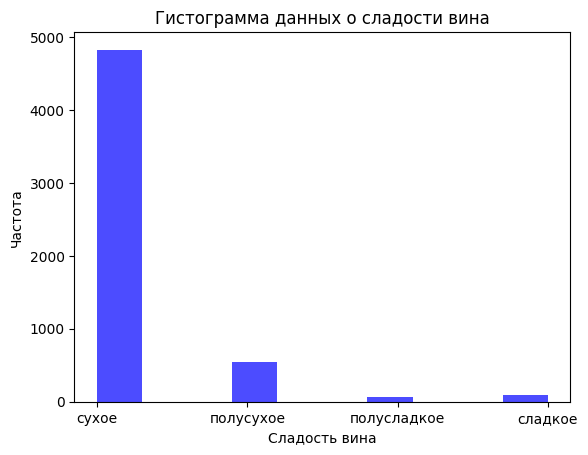

In [27]:
plt.hist(df['sugar'], bins=10, color='blue', alpha=0.7)
plt.xlabel('Сладость вина')
plt.ylabel('Частота')
plt.title('Гистограмма данных о сладости вина')
plt.show()

Как можно увидеть выборка в основном представлена сухими винами.

Посмотрим на взаимосвязь цены за бутылку вина от её характеристик.

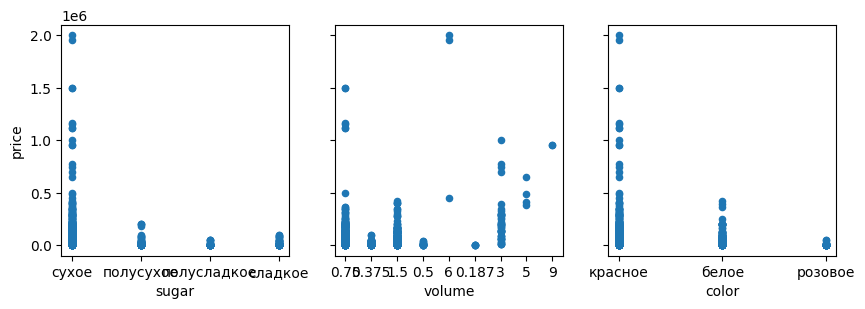

In [31]:
fig, axs = plt.subplots(1, 3, sharey=True)

df.plot(kind='scatter', x='sugar', y='price', ax=axs[0], figsize=(10, 3))
df.plot(kind='scatter', x='volume', y='price', ax=axs[1])
df.plot(kind='scatter', x='color', y='price', ax=axs[2]);

Как можно увидеть, полусухое, полусладкое и сладкое вино в среднем сильно дешевле сухого (если смотреть на полученную шкалу цен). Также красное вино имеет больший разброс цен, чем белое и розовое. Это может быть связано с тем, что в выборке представлено больше красного вина. Про объем можно лишь сказать, что имеется очень сильный разброс значений

 ## **Гипотезы**

#### **H0:** объем бутылки вина положительно коррелирует с ценой


#### **H1:** красное полусухое вино будет стоить дороже, чем другие виды

#### **H2:** Чем меньше год производства вина, тем оно будет стоить дороже

**H3:** Вино, произведённое во Франции стоит в среднем дороже